# Final Project: 某闯关类手游用户流失预测

## 一、案例简介

手游在当下的日常娱乐中占据着主导性地位，成为人们生活中放松身心的一种有效途径。近年来，各种类型的手游，尤其是闯关类的休闲手游，由于其对碎片化时间的利用取得了非常广泛的市场。然而在此类手游中，新用户流失是一个非常严峻的问题，有相当多的新用户在短暂尝试后会选择放弃，而如果能在用户还没有完全卸载游戏的时候针对流失可能性较大的用户施以干预（例如奖励道具、暖心短信），就可能挽回用户从而提升游戏的活跃度和公司的潜在收益，因此用户的流失预测成为一个重要且挑战性的问题。在毕业项目中我们将从真实游戏中非结构化的日志数据出发，构建用户流失预测模型，综合已有知识设计适合的算法解决实际问题。

## 二、作业说明

* 根据给出的实际数据（包括用户游玩历史，关卡特征等），预测测试集中的用户是否为流失用户（二分类）；
* 方法不限，使用百度云进行评测，评价指标使用 AUC；
* 提交代码与实验报告，报告展示对数据的观察、分析、最后的解决方案以及不同尝试的对比等；
* 最终评分会参考达到的效果以及对所尝试方法的分析。

## 三、数据概览

本次使用的是一个休闲类闯关手游的数据，用户在游戏中不断闯关，每一关的基本任务是在限定步数内达到某个目标。每次闯关可能成功也可能失败，一般情况下用户只在完成一关后进入下一关，闯关过程中可以使用道具或提示等帮助。

对大多数手游来说，用户流失往往发生在早期，因此次周的留存情况是公司关注的一个重点。本次数据选取了 2020.2.1 注册的所有用户在 2.1-2.4 的交互数据，数据经过筛选保证这些注册用户在前四日至少有两日登录。流失的定义则参照次周（2.7-2.13）的登录情况，如果没有登录为流失。

本次的数据和以往结构化的形式不同，展现的是更原始的数据记录，更接近公司实际日志的形式，共包含 5 个文件：

### train.csv

训练集用户，包括用户 id（从 1 开始）以及对应是否为流失用户的 label（1：流失，0：留存）。

In [1]:
import pandas as pd
import numpy as np

train_df = pd.read_csv('./data/train.csv', sep='\t')
train_df.T

,0,1,2,3,4,5,6,7,8,9,...,8148,8149,8150,8151,8152,8153,8154,8155,8156,8157
user_id,2774,2775,2776,2777,2778,2779,2780,2781,2782,2783,...,10922,10923,10924,10925,10926,10927,10928,10929,10930,10931
label,0,0,1,0,1,1,0,0,0,1,...,0,0,0,1,1,1,1,0,1,0


In [2]:
train_df['label'].value_counts()

0    5428
1    2730
Name: label, dtype: int64

训练集共 8158 个用户，其中流失用户大约占 1/3，需要注意的是为了匿名化，这里数据都经过一定的非均匀抽样处理，流失率并不反映实际游戏的情况，用户与关卡的 id 同样经过了重编号，但对于流失预测任务来说并没有影响。

### dev.csv

验证集格式和训练集相同，主要为了方便离线测试与模型选择。

In [3]:
dev_df = pd.read_csv('./data/dev.csv', sep='\t')
dev_df.T

,0,1,2,3,4,5,6,7,8,9,...,2648,2649,2650,2651,2652,2653,2654,2655,2656,2657
user_id,10932,10933,10934,10935,10936,10937,10938,10939,10940,10941,...,13580,13581,13582,13583,13584,13585,13586,13587,13588,13589
label,0,1,0,1,0,0,0,0,0,1,...,0,1,1,0,1,0,0,0,1,0


### test.csv
测试集只包含用户 id，任务就是要预测这些用户的流失概率。

In [4]:
test_df = pd.read_csv('./data/test.csv', sep='\t')
test_df.T

,0,1,2,3,4,5,6,7,8,9,...,2763,2764,2765,2766,2767,2768,2769,2770,2771,2772
user_id,1,2,3,4,5,6,7,8,9,10,...,2764,2765,2766,2767,2768,2769,2770,2771,2772,2773


### level_seq.csv
这个是核心的数据文件，包含用户游玩每个关卡的记录，每一条记录是对某个关卡的一次尝试，具体每列的含义如下：

* `user_id`：用户 id，和训练、验证、测试集中的可以匹配；
* `level_id`：关卡 id；
* `f_success`：是否通关（1：通关，0：失败）；
* `f_duration`：此次尝试所用的时间（单位 s）；
* `f_reststep`：剩余步数与限定步数之比（失败为 0）；
* `f_help`：是否使用了道具、提示等额外帮助（1：使用，0：未使用）；
* `time`：时间戳。

In [5]:
seq_df = pd.read_csv('./data/level_seq.csv', sep='\t')
seq_df

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time
0,10932,1,1,127.0,0.500000,0,2020-02-01 00:05:51
1,10932,2,1,69.0,0.703704,0,2020-02-01 00:08:01
2,10932,3,1,67.0,0.560000,0,2020-02-01 00:09:50
3,10932,4,1,58.0,0.700000,0,2020-02-01 00:11:16
4,10932,5,1,83.0,0.666667,0,2020-02-01 00:13:12
...,...,...,...,...,...,...,...
2194346,10931,40,1,111.0,0.250000,1,2020-02-03 16:26:37
2194347,10931,41,1,76.0,0.277778,0,2020-02-03 16:28:06
2194348,10931,42,0,121.0,0.000000,1,2020-02-03 16:30:17
2194349,10931,42,0,115.0,0.000000,0,2020-02-03 16:33:40


### level_meta.csv
每个关卡的一些统计特征，可用于表示关卡，具体每列的含义如下：

* `f_avg_duration`：平均每次尝试花费的时间（单位 s，包含成功与失败的尝试）；
* `f_avg_passrate`：平均通关率；
* `f_avg_win_duration`：平均每次通关花费的时间（单位 s，只包含通关的尝试）；
* `f_avg_retrytimes`：平均重试次数（第二次玩同一关算第 1 次重试）；
* `level_id`：关卡 id，可以和 level_seq.csv 中的关卡匹配。

In [6]:
meta_df = pd.read_csv('./data/level_meta.csv', sep='\t')
meta_df

,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes,level_id
0,39.889940,0.944467,35.582757,0.017225,1
1,60.683975,0.991836,56.715706,0.004638,2
2,76.947355,0.991232,71.789943,0.004480,3
3,58.170347,0.993843,54.842882,0.004761,4
4,101.784577,0.954170,85.650547,0.027353,5
...,...,...,...,...,...
1504,594.878788,0.453730,133.625000,3.187500,1505
1505,486.562500,0.454180,115.906250,3.218750,1506
1506,325.968750,0.573525,86.250000,2.687500,1507
1507,793.096774,0.322684,164.000000,5.419355,1508


## 四、Tips

* 一个基本的思路可以是：根据游玩关卡的记录为每个用户提取特征 → 结合 label 构建表格式的数据集 → 使用不同模型训练与测试；
* 还可以借助其他模型（如循环神经网络）直接对用户历史序列建模；
* 数据量太大运行时间过长的话，可以先在一个采样的小训练集上调参；
* 集成多种模型往往能达到更优的效果；
* 可以使用各种开源工具。

In [7]:
seq_df.describe()

,user_id,level_id,f_success,f_duration,f_reststep,f_help
count,2.194351e+06,2.194351e+06,2.194351e+06,2.194351e+06,2.194351e+06,2.194351e+06
mean,6.745030e+03,9.683600e+01,5.283216e-01,1.081228e+02,1.678471e-01,4.415565e-02
std,3.942094e+03,8.410689e+01,4.991974e-01,5.361323e+01,2.261460e-01,2.054409e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.287000e+03,4.100000e+01,0.000000e+00,7.700000e+01,0.000000e+00,0.000000e+00
50%,6.688000e+03,8.000000e+01,1.000000e+00,1.000000e+02,4.545455e-02,0.000000e+00
75%,1.016300e+04,1.420000e+02,1.000000e+00,1.270000e+02,2.857143e-01,0.000000e+00
max,1.358900e+04,1.509000e+03,1.000000e+00,6.000000e+02,1.000000e+00,1.000000e+00


In [8]:
# 以id=2776为例（stay），分析留下用户手游数据
stay_example = seq_df[seq_df['user_id'] == 2776]
stay_example = stay_example.merge(meta_df, how='left', on='level_id')
# stay_example.describe()
stay_example

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes
0,2776,29,1,81.0,0.333333,0,2020-02-01 00:05:21,89.701641,0.984955,81.930473,0.008521
1,2776,30,1,104.0,0.230769,0,2020-02-01 00:07:45,133.512312,0.867726,92.249032,0.133288
2,2776,31,1,62.0,0.605263,0,2020-02-01 00:10:16,138.184708,0.829723,83.820161,0.167420
3,2776,32,1,42.0,0.791667,0,2020-02-01 00:11:53,166.266343,0.775116,85.527433,0.352216
4,2776,33,1,46.0,0.433333,0,2020-02-01 00:13:28,113.750504,0.939009,82.450051,0.109896
...,...,...,...,...,...,...,...,...,...,...,...
64,2776,69,0,108.0,0.000000,0,2020-02-03 00:09:29,172.822415,0.818851,104.704529,0.280615
65,2776,69,1,123.0,0.045455,0,2020-02-03 13:28:27,172.822415,0.818851,104.704529,0.280615
66,2776,70,0,162.0,0.000000,0,2020-02-03 13:31:11,268.674456,0.697015,122.197748,0.528360
67,2776,70,0,86.0,0.000000,0,2020-02-03 13:56:46,268.674456,0.697015,122.197748,0.528360


In [9]:
# 以id=2775为例（leave），分析流失用户手游数据
leave_example = seq_df[seq_df['user_id'] == 2775]
leave_example = leave_example.merge(meta_df, how='left', on='level_id')
# leave_example.describe()
leave_example

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes
0,2775,1,1,24.0,0.50000,0,2020-02-01 00:02:27,39.889940,0.944467,35.582757,0.017225
1,2775,2,1,58.0,0.62963,0,2020-02-01 00:04:27,60.683975,0.991836,56.715706,0.004638
2,2775,3,1,71.0,0.52000,0,2020-02-01 00:32:35,76.947355,0.991232,71.789943,0.004480
3,2775,4,1,49.0,0.70000,0,2020-02-01 00:33:32,58.170347,0.993843,54.842882,0.004761
4,2775,5,1,49.0,0.87500,0,2020-02-01 00:35:00,101.784577,0.954170,85.650547,0.027353
...,...,...,...,...,...,...,...,...,...,...,...
106,2775,81,0,178.0,0.00000,0,2020-02-04 21:09:40,241.180872,0.645339,101.586450,0.679560
107,2775,81,0,311.0,0.00000,0,2020-02-04 21:14:53,241.180872,0.645339,101.586450,0.679560
108,2775,81,0,154.0,0.00000,0,2020-02-04 21:17:33,241.180872,0.645339,101.586450,0.679560
109,2775,81,0,97.0,0.00000,0,2020-02-04 21:19:15,241.180872,0.645339,101.586450,0.679560


In [20]:
level_columns = ['user_id', 'level_id', 'count', 'duration_avg', 'success_count', 'win_duration_avg',
                 'fail_duration_avg', 'win_reststep_avg', 'fail_reststep_avg', 'retry_times', 'help_avg', 'date_times',
                 'first_time', 'last_time']
user_columns = ['user_id', 'count', 'duration_avg', 'success_count', 'win_duration_avg', 'fail_duration_avg',
                'win_reststep_avg', 'fail_reststep_avg', 'retry_times_avg', 'help_avg', 'date_covered', 'mini_level',
                'max_level', 'start_level',
                'last_level', 'level_num', 'last_level_pass', 'uf_avg_duration', 'uf_avg_passrate',
                'uf_avg_win_duration', 'uf_avg_retrytimes']
date_list = ['2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04']


In [3]:
# 用户闯关数据分析
def level_analyze(data):
    user_id = data[0][0]
    level_id = data[0][1]
    print("handling user_id = {}, level_id = {}".format(user_id, level_id))
    df = data[1].sort_values(by=['time'], ignore_index=True)
    count = len(df['user_id'])
    duration_avg = np.average(df['f_duration'])
    success_df = df[df['f_success'] == 1]
    fail_df = df[df['f_success'] == 0]
    success_count = success_df.shape[0]
    win_duration = np.sum(success_df['f_duration'])
    win_duration_avg = 0 if success_count == 0 else win_duration / success_count
    fail_duration = np.sum(fail_df['f_duration'])
    fail_duration_avg = 0 if count == success_count else fail_duration / (count - success_count)
    win_reststep_avg = 0 if success_count == 0 else np.sum(success_df['f_reststep']) / success_count
    fail_reststep_avg = 0 if count == success_count else np.sum(fail_df['f_reststep']) / (count - success_count)
    retry_times = count - 1
    help_avg = np.average(df['f_help'])
    date_times = '|'.join(df['time'])
    first_time = df['time'][0]
    last_time = df['time'][count - 1]
    return [user_id, level_id, count, duration_avg, success_count,
            win_duration_avg, fail_duration_avg, win_reststep_avg, fail_reststep_avg, retry_times, help_avg, date_times,
            first_time, last_time]

In [4]:
# 用户特征/画像构建
def user_analyze(data):
    # user_id: 用户id
    user_id = data[0]
    print("handling user_id = {}".format(user_id))
    df = data[1]
    # count: 闯关记录数
    count = np.sum(df['count'])
    # duration_avg: 平均耗时
    duration = np.sum(df['count'] * df['duration_avg'])
    duration_avg = 0 if count == 0 else duration / count
    # success_count: 通关次数
    success_count = np.sum(df['success_count'])
    # win_duration_avg: 通关平均耗时
    win_duration = np.sum(df['success_count'] * df['win_duration_avg'])
    win_duration_avg = 0 if success_count == 0 else win_duration / success_count
    # fail_duration_avg: 未通关平均耗时
    fail_duration_avg = 0 if count == success_count else (duration - win_duration) / (count - success_count)
    # win_reststep_avg: 通关剩余步数比例平均值
    win_reststep_avg = 0 if success_count == 0 else np.sum(df['success_count'] * df['win_reststep_avg']) / success_count
    # fail_reststep_avg: 未通关剩余步数比例平均值
    fail_reststep_avg = 0 if count == success_count else np.sum(
        df['fail_reststep_avg'] * (df['count'] - df['success_count'])) / (count - success_count)
    # retry_times_avg: 平均重试次数
    retry_times_avg = np.average(df['retry_times'])
    # help_avg: 辅助平均使用次数
    help_avg = np.average(df['help_avg'])
    # date_covered: 涵盖的日期（2/1 - 2/4）
    date_covered = 0
    all_times = '|'.join(df['date_times'])
    for date in date_list:
        date_covered += (1 if all_times.find(date) > -1 else 0)
    # mini_level: 最小关卡
    mini_level = np.min(df['level_id'])
    # max_level: 最大关卡
    max_level = np.max(df['level_id'])
    # start_level: 起始关卡
    start_level = df.sort_values(by=['first_time'], ascending=True).iloc[0].at['level_id']
    # last_level: 最终关卡
    last_record = df.sort_values(by=['last_time'], ascending=False).iloc[0]
    last_level = last_record.at['level_id']
    # level_num: 经过的关卡数
    level_num = df.shape[0]
    # last_level_pass: 最终关卡是否通过
    last_level_pass = 1 if last_record.at['success_count'] > 0 else 0
    # 关卡属性
    # uf_avg_duration：用户经过关卡，平均每次尝试花费的时间
    uf_avg_duration = np.average(df['f_avg_duration'])
    # uf_avg_passrate：用户经过关卡，平均通关率
    uf_avg_passrate = np.average(df['f_avg_passrate'])
    # uf_avg_win_duration：用户经过关卡，平均每次通关花费的时间
    uf_avg_win_duration = np.average(df['f_avg_win_duration'])
    # uf_avg_retrytimes： 用户经过关卡，平均重试次数
    uf_avg_retrytimes = np.average(df['f_avg_retrytimes'])
    return [user_id, count, duration_avg, success_count, win_duration_avg, fail_duration_avg, win_reststep_avg,
            fail_reststep_avg, retry_times_avg, help_avg, date_covered, mini_level, max_level, start_level, last_level,
            level_num, last_level_pass, uf_avg_duration, uf_avg_passrate, uf_avg_win_duration, uf_avg_retrytimes]


In [13]:
# 数据清洗
all_train_df = pd.concat([train_df, dev_df], ignore_index=True)
# 1. 没用步数却通关，视为脏数据（观察user_id=10963发现）
dirty_percent = seq_df[(seq_df['f_reststep'] == 1.0) & (seq_df['f_success'] == 1)].shape[0] / seq_df[(seq_df['f_reststep'] == 1.0)].shape[0]
print("1. 没用步数却通关，视为脏数据，占'没用步数'数据比例 = {}".format(dirty_percent))
# 2. 同一用户在同一时间玩同一关卡，视为脏数据（观察user_id=2775发现）
ex = seq_df.groupby(['user_id', 'time', 'level_id']).agg({"user_id": ["count"]})
duplicated_num = ex.loc[ex[('user_id', 'count')] > 1][('user_id', 'count')].sum()
print("2. 同一用户在同一时间玩同一关卡，视为脏数据，占比 = {}".format(duplicated_num / seq_df.shape[0]))
# 3. 含有未通关但f_reststep并不为0记录（不符合题设要求的），经分析需要保留不做为脏数据
fail_but_reststep_df = pd.merge(
    seq_df[(seq_df['f_reststep'] != 0.0) & (seq_df['f_success'] == 0)]['user_id'].drop_duplicates(),
    all_train_df, how='left', on='user_id').dropna()
fail_but_reststep_percent = len(fail_but_reststep_df[fail_but_reststep_df['label'] == 1]) / fail_but_reststep_df.shape[
    0]
print("3. 含有未通关但f_reststep并不为0记录（不符合题设要求）的用户，其中的留存比率 = {}".format(fail_but_reststep_percent))
# 去除脏数据
seq_df.drop(seq_df.index[(seq_df['f_reststep'] == 1.0) & (seq_df['f_success'] == 1)], inplace=True)
seq_df.drop_duplicates(subset=['user_id', 'time', 'level_id'], inplace=True)
print("数据清洗完成！")

1. 没用步数却通关，视为脏数据，占'没用步数'数据比例 = 0.32742017232640647
2. 同一用户在同一时间玩同一关卡，视为脏数据，占比 = 0.03895092444189649
3. 含有未通关但f_reststep并不为0记录（不符合题设要求的）的用户，其中的留存比率 = 0.3074743952930922
数据清洗完成！


### 数据清洗分析
1. 没用步数却通关，视为脏数据，占'没用步数'数据比例 = 0.32742017232640647
2. 同一用户在同一时间玩同一关卡，视为脏数据，占比 = 0.03895092444189649
3. 含有未通关但f_reststep并不为0记录（不符合题设要求）的用户，其中的留存比率 = 0.3074743952930922，对用户流失有影响，所以数据保留，不视为脏数据

In [ ]:
import multiprocessing

# 取样例数据分析
pool = multiprocessing.Pool()
examples = seq_df[(seq_df['user_id'] == 2775) | (seq_df['user_id'] == 2776)]
grouped = examples.groupby(['user_id', 'level_id'])
res = pool.map(level_analyze, grouped)
exdf = pd.DataFrame(res, columns=level_columns)
exdf = exdf.merge(meta_df, how='left', on='level_id')
exdf.to_csv('./level_analyze.csv')
# 对比用户闯关特征数据同关卡属性，并没有发现某个关卡对用户而言，难度系数如何
# 但仍基于以上用户闯关特征提取该游戏对于用户而言的特征

### 用户闯关特征

* `user_id`：用户id
* `level_id`：关卡id
* `count`：用户在该关卡记录数
* `duration_avg`：用户在该关卡平均耗时
* `success_count`：用户在该关卡通关记录数
* `win_duration_avg`：用户在该关卡通关平均耗时
* `fail_duration_avg`：用户在该关卡未通关平均耗时
* `win_reststep_avg`：用户在该关卡通关剩余步数平均比例
* `fail_reststep_avg`：用户在该关卡未通关剩余步数平均比例
* `retry_times`：用户在该关卡重试次数
* `help_avg`：用户在该关卡使用道具平均次数
* `date_times`：用户在该关卡时间记录，|分隔
* `first_time`：用户在该关卡第一次玩游戏时间
* `last_time`：用户在该关卡最后一次玩游戏时间


In [ ]:
# 用户闯关特征
all_train_seq_df = all_train_df.merge(seq_df, how='left', on='user_id')
user_level_grouped = all_train_seq_df.groupby(['user_id', 'level_id'])
user_level_analyze_list = pool.map(level_analyze, user_level_grouped)
user_level_analyze_df = pd.DataFrame(user_level_analyze_list, columns=level_columns)
user_level_analyze_df = user_level_analyze_df.merge(meta_df, how='left', on='level_id')
user_level_analyze_df.to_csv('./user_level_analyze.csv', index=False)

### 针对该游戏，用户特征/画像

* `user_id`：用户id
* `count`：闯关记录数
* `duration_avg`：平均耗时
* `success_count`：通关次数
* `win_duration_avg`：通关平均耗时
* `fail_duration_avg`：未通关平均耗时
* `win_reststep_avg`：通关剩余步数比例平均值
* `fail_reststep_avg`：未通关剩余步数比例平均值
* `retry_times_avg`：平均重试次数
* `help_avg`：辅助平均使用次数
* `date_covered`：涵盖的日期（2/1 - 2/4）
* `mini_level`：最小关卡
* `max_level`：最大关卡
* `start_level`：起始关卡
* `last_level`：最终关卡
* `level_num`：经过的关卡数
* `last_level_pass`：最终关卡是否通过
关卡属性
* `uf_avg_duration`：用户经过关卡，平均每次尝试花费的时间
* `uf_avg_passrate`：用户经过关卡，平均通关率
* `uf_avg_win_duration`：用户经过关卡，平均每次通关花费的时间
* `uf_avg_retrytimes`：用户经过关卡，平均重试次数

In [ ]:
# 针对该游戏，用户特征/画像
user_grouped = user_level_analyze_df.groupby(['user_id'])
user_analyze_list = pool.map(user_analyze, user_grouped)
user_analyze_df = pd.DataFrame(user_analyze_list, columns=user_columns)
user_analyze_df.to_csv('./user_analyze.csv', index=False)


                                     0
label同user_id相关性              0.013656
label同count相关性               -0.311665
label同duration_avg相关性        -0.193585
label同success_count相关性       -0.356026
label同win_duration_avg相关性    -0.199122
label同fail_duration_avg相关性   -0.118978
label同win_reststep_avg相关性     0.373614
label同fail_reststep_avg相关性    0.112174
label同retry_times_avg相关性     -0.197450
label同help_avg相关性            -0.052554
label同date_covered相关性        -0.454448
label同mini_level相关性          -0.010939
label同max_level相关性           -0.288662
label同start_level相关性         -0.009706
label同last_level相关性          -0.299858
label同level_num相关性           -0.361728
label同last_level_pass相关性      0.181041
label同uf_avg_duration相关性     -0.359955
label同uf_avg_passrate相关性      0.364336
label同uf_avg_win_duration相关性 -0.385048
label同uf_avg_retrytimes相关性   -0.283064
label同label相关性                1.000000


array([[<AxesSubplot: xlabel='user_id', ylabel='user_id'>,
        <AxesSubplot: xlabel='label', ylabel='user_id'>,
        <AxesSubplot: xlabel='count', ylabel='user_id'>,
        <AxesSubplot: xlabel='duration_avg', ylabel='user_id'>,
        <AxesSubplot: xlabel='success_count', ylabel='user_id'>,
        <AxesSubplot: xlabel='win_duration_avg', ylabel='user_id'>,
        <AxesSubplot: xlabel='fail_duration_avg', ylabel='user_id'>,
        <AxesSubplot: xlabel='win_reststep_avg', ylabel='user_id'>,
        <AxesSubplot: xlabel='fail_reststep_avg', ylabel='user_id'>,
        <AxesSubplot: xlabel='retry_times_avg', ylabel='user_id'>,
        <AxesSubplot: xlabel='help_avg', ylabel='user_id'>,
        <AxesSubplot: xlabel='date_covered', ylabel='user_id'>,
        <AxesSubplot: xlabel='mini_level', ylabel='user_id'>,
        <AxesSubplot: xlabel='max_level', ylabel='user_id'>,
        <AxesSubplot: xlabel='start_level', ylabel='user_id'>,
        <AxesSubplot: xlabel='last_level', ylab

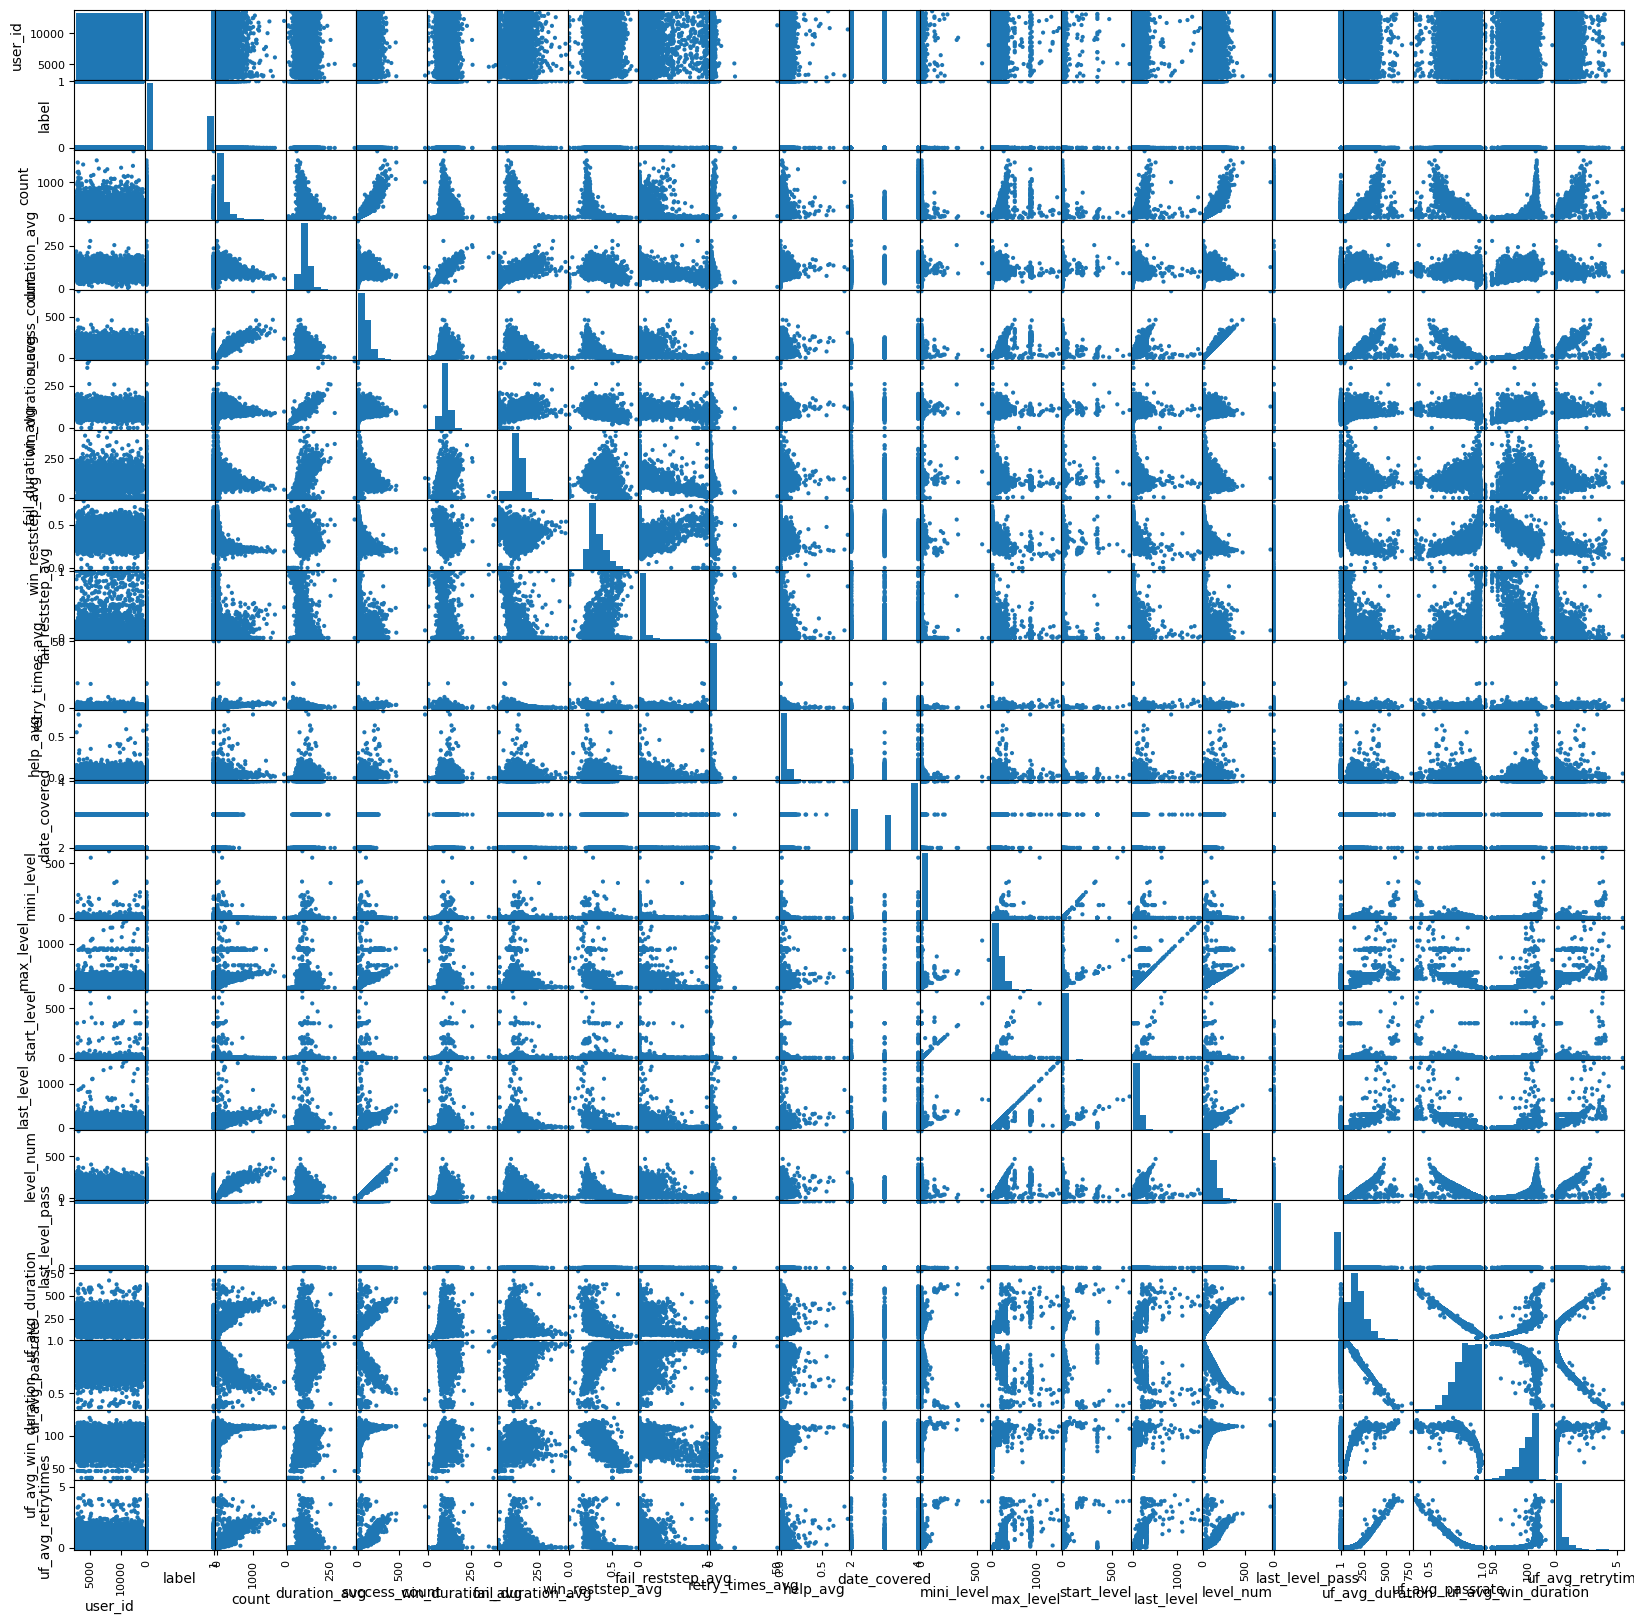

In [21]:
import pandas as pd
import numpy as np

train_df = pd.read_csv('./data/train.csv', sep='\t')
dev_df = pd.read_csv('./data/dev.csv', sep='\t')
user_analyze_df = pd.read_csv('./user_analyze.csv')
# analyze 相关性
all_train_df = pd.concat([train_df, dev_df], ignore_index=True)
all_train_feat_df = all_train_df.merge(user_analyze_df, how='left', on='user_id')
r = np.corrcoef(all_train_feat_df[user_columns], all_train_feat_df['label'], rowvar=False)
user_columns_extend = user_columns.copy()
user_columns_extend.append('label')
corr_columns = ['label同' + name + '相关性' for name in user_columns_extend]
r_yx = pd.DataFrame(r[:, -1].T, index=corr_columns)
print(r_yx)
pd.plotting.scatter_matrix(all_train_feat_df, alpha=1.0, figsize=(20, 20))


### 特征分析
根据以上特征值同label的相关性分析，移除以下特征
* user_id(0.013656)
* help_avg(-0.052554)
* mini_level(-0.010939)
* start_level(-0.009706)

### 以下对测试集做用户闯关特征提取 -> 用户画像

In [ ]:
import pandas as pd

# 对测试集做用户闯关特征提取 -> 用户画像
test_df = pd.read_csv('./data/test.csv', sep='\t')
seq_df = pd.read_csv('./data/level_seq.csv', sep='\t')
meta_df = pd.read_csv('./data/level_meta.csv', sep='\t')
# 数据清洗
# 1. 没用步数却通关，视为脏数据（观察user_id=10963发现）
dirty_percent = seq_df[(seq_df['f_reststep'] == 1.0) & (seq_df['f_success'] == 1)].shape[0] / seq_df[(seq_df['f_reststep'] == 1.0)].shape[0]
print("1. 没用步数却通关，视为脏数据，占'没用步数'数据比例 = {}".format(dirty_percent))
# 2. 同一用户在同一时间玩同一关卡，视为脏数据（观察user_id=2775发现）
ex = seq_df.groupby(['user_id', 'time', 'level_id']).agg({"user_id": ["count"]})
duplicated_num = ex.loc[ex[('user_id', 'count')] > 1][('user_id', 'count')].sum()
print("2. 同一用户在同一时间玩同一关卡，视为脏数据，占比 = {}".format(duplicated_num / seq_df.shape[0]))
# 3. 含有未通关但f_reststep并不为0记录（不符合题设要求的），经分析需要保留不做为脏数据
fail_but_reststep_df = pd.merge(
    seq_df[(seq_df['f_reststep'] != 0.0) & (seq_df['f_success'] == 0)]['user_id'].drop_duplicates(),
    all_train_df, how='left', on='user_id').dropna()
fail_but_reststep_percent = len(fail_but_reststep_df[fail_but_reststep_df['label'] == 1]) / fail_but_reststep_df.shape[
    0]
print("3. 含有未通关但f_reststep并不为0记录（不符合题设要求）的用户，其中的留存比率 = {}".format(fail_but_reststep_percent))
# 去除脏数据
seq_df.drop(seq_df.index[(seq_df['f_reststep'] == 1.0) & (seq_df['f_success'] == 1)], inplace=True)
seq_df.drop_duplicates(subset=['user_id', 'time', 'level_id'], inplace=True)
print("数据清洗完成！")

# 针对测试集
test_seq_df = test_df.merge(seq_df, how='left', on='user_id')
user_level_test_grouped = test_seq_df.groupby(['user_id', 'level_id'])
user_level_test_analyze_list = pool.map(level_analyze, user_level_test_grouped)
user_level_test_analyze_df = pd.DataFrame(user_level_test_analyze_list, columns=level_columns)
user_level_test_analyze_df = user_level_test_analyze_df.merge(meta_df, how='left', on='level_id')
user_level_test_analyze_df.to_csv('./user_level_test_analyze.csv', index=False)

user_test_grouped = user_level_test_analyze_df.groupby(['user_id'])
user_test_analyze_list = pool.map(user_analyze, user_test_grouped)
user_test_analyze_df = pd.DataFrame(user_test_analyze_list, columns=user_columns)
user_test_analyze_df.to_csv('./user_test_analyze.csv', index=False)
print("对测试集做用户闯关特征提取 -> 用户画像，完成！")

In [15]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, accuracy_score
import time


# 分类器构造函数
def construct_clf(clf_name):
    clf = None
    if clf_name == 'SVM':
        clf = svm.LinearSVC(dual=False, tol=1e-5)
    elif clf_name == 'DTree':
        clf = DecisionTreeClassifier(max_depth=5, random_state=2022)
    elif clf_name == 'NB':
        clf = MultinomialNB()
    elif clf_name == 'KNN':
        clf = KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=8)
    elif clf_name == 'BAGG-SVM':
        clf = BaggingClassifier(base_estimator=svm.LinearSVC(dual=False, tol=1e-5), n_estimators=50, max_samples=0.8,
                                n_jobs=8, random_state=2022)
    elif clf_name == 'BAGG-DTree':
        clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5, random_state=2022), n_estimators=50,
                                max_samples=0.8, n_jobs=8, random_state=2022)
    elif clf_name == 'BAGG-NB':
        clf = BaggingClassifier(base_estimator=MultinomialNB(), n_estimators=50, max_samples=0.8, n_jobs=8,
                                random_state=2022)
    elif clf_name == 'BAGG-KNN':
        clf = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=8),
                                n_estimators=50, max_samples=0.8, n_jobs=8, random_state=2022)
    elif clf_name == 'AB-DTree':
        clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10, random_state=2022),
                                 n_estimators=100, random_state=2022)
    elif clf_name == 'AB-NB':
        clf = AdaBoostClassifier(base_estimator=MultinomialNB(), n_estimators=100, random_state=2022)
    elif clf_name == 'AB-KNN':
        clf = AdaBoostClassifier(base_estimator=KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=8),
                                 n_estimators=100, random_state=2022)
    clf = CalibratedClassifierCV(clf, cv=2, method='sigmoid')  # 概率校正
    return clf


user_columns = ['count', 'duration_avg', 'success_count', 'win_duration_avg', 'fail_duration_avg',
                'win_reststep_avg', 'fail_reststep_avg', 'retry_times_avg', 'date_covered',
                'max_level', 'last_level', 'level_num', 'last_level_pass', 'uf_avg_duration', 'uf_avg_passrate',
                'uf_avg_win_duration', 'uf_avg_retrytimes']

train_df = pd.read_csv('./data/train.csv', sep='\t')
dev_df = pd.read_csv('./data/dev.csv', sep='\t')
test_df = pd.read_csv('./data/test.csv', sep='\t')
user_analyze_df = pd.read_csv('./user_analyze.csv')
user_test_analyze_df = pd.read_csv('./user_test_analyze.csv')
# 移除相关性低的特征
# user_columns.remove('user_id')
# user_columns.remove('help_avg')
# user_columns.remove('mini_level')
# user_columns.remove('start_level')
# fit & predict
train_feat_df = train_df.merge(user_analyze_df, how='left', on='user_id')
x_train = train_feat_df[user_columns]
y_train = train_feat_df['label']
dev_feat_df = dev_df.merge(user_analyze_df, how='left', on='user_id')
x_dev = dev_feat_df[user_columns]
y_dev = dev_feat_df['label']
# using SVM
clf_svm = construct_clf('SVM')
clf_svm.fit(x_train, y_train)
print('accuracy using SVM = {}'.format(accuracy_score(y_dev, clf_svm.predict(x_dev))))
print('auc using SVM = {}'.format(roc_auc_score(y_dev, clf_svm.predict_proba(x_dev)[:, 1])))
# using Decision Tree
clf_dt = construct_clf('DTree')
clf_dt.fit(x_train, y_train)
print('accuracy using Decision Tree = {}'.format(accuracy_score(y_dev, clf_dt.predict(x_dev))))
print('auc using Decision Tree = {}'.format(roc_auc_score(y_dev, clf_dt.predict_proba(x_dev)[:, 1])))
# using NB
clf_nb = construct_clf('NB')
clf_nb.fit(x_train, y_train)
print('accuracy using NB = {}'.format(accuracy_score(y_dev, clf_nb.predict(x_dev))))
print('auc using NB = {}'.format(roc_auc_score(y_dev, clf_nb.predict_proba(x_dev)[:, 1])))
# using KNN
clf_knn = construct_clf('KNN')
clf_knn.fit(x_train, y_train)
print('accuracy using KNN = {}'.format(accuracy_score(y_dev, clf_knn.predict(x_dev))))
print('auc using KNN = {}'.format(roc_auc_score(y_dev, clf_knn.predict_proba(x_dev)[:, 1])))
# using Bagging
clf_bagg_dt = construct_clf('BAGG-DTree')
clf_bagg_dt.fit(x_train, y_train)
print('accuracy using BAGG-DTree = {}'.format(accuracy_score(y_dev, clf_bagg_dt.predict(x_dev))))
y_bagg_dt_predict_proba = clf_bagg_dt.predict_proba(x_dev)[:, 1]
print('auc using BAGG-DTree = {}'.format(roc_auc_score(y_dev, y_bagg_dt_predict_proba)))
clf_bagg_nb = construct_clf('BAGG-NB')
clf_bagg_nb.fit(x_train, y_train)
print('accuracy using BAGG-NB = {}'.format(accuracy_score(y_dev, clf_bagg_nb.predict(x_dev))))
print('auc using BAGG-NB = {}'.format(roc_auc_score(y_dev, clf_bagg_nb.predict_proba(x_dev)[:, 1])))
clf_bagg_knn = construct_clf('BAGG-KNN')
clf_bagg_knn.fit(x_train, y_train)
print('accuracy using BAGG-KNN = {}'.format(accuracy_score(y_dev, clf_bagg_knn.predict(x_dev))))
print('auc using BAGG-KNN = {}'.format(roc_auc_score(y_dev, clf_bagg_knn.predict_proba(x_dev)[:, 1])))
clf_bagg_svm = construct_clf('BAGG-SVM')
clf_bagg_svm.fit(x_train, y_train)
print('accuracy using BAGG-SVM = {}'.format(accuracy_score(y_dev, clf_bagg_svm.predict(x_dev))))
print('auc using BAGG-SVM = {}'.format(roc_auc_score(y_dev, clf_bagg_svm.predict_proba(x_dev)[:, 1])))
# using AdaBoost
clf_ab_dt = construct_clf('AB-DTree')
clf_ab_dt.fit(x_train, y_train)
print('accuracy using AB-DTree = {}'.format(accuracy_score(y_dev, clf_ab_dt.predict(x_dev))))
print('auc using AB-DTree = {}'.format(roc_auc_score(y_dev, clf_ab_dt.predict_proba(x_dev)[:, 1])))
clf_ab_nb = construct_clf('AB-NB')
clf_ab_nb.fit(x_train, y_train)
print('accuracy using AB-NB = {}'.format(accuracy_score(y_dev, clf_ab_nb.predict(x_dev))))
print('auc using AB-NB = {}'.format(roc_auc_score(y_dev, clf_ab_nb.predict_proba(x_dev)[:, 1])))


accuracy using SVM = 0.735515425131678
auc using SVM = 0.7841897038451554
accuracy using Decision Tree = 0.7310007524454477
auc using Decision Tree = 0.7720195798382495
accuracy using NB = 0.6610233258088789
auc using NB = 0.7044882148905568
accuracy using KNN = 0.6824680210684725
auc using KNN = 0.7064802467630668
accuracy using BAGG-DTree = 0.7381489841986456
auc using BAGG-DTree = 0.7862603810222879
accuracy using BAGG-NB = 0.6610233258088789
auc using BAGG-NB = 0.7080929492747261
accuracy using BAGG-KNN = 0.6930022573363431
auc using BAGG-KNN = 0.721723222852999
accuracy using BAGG-SVM = 0.736267870579383
auc using BAGG-SVM = 0.7844316408063639
accuracy using AB-DTree = 0.7099322799097065
auc using AB-DTree = 0.766679911083429
accuracy using AB-NB = 0.6610233258088789
auc using AB-NB = 0.510078916930976


### 2022-11-26： 根据对以上各个模型的调参结果，最终确定使用Bagging + DecisionTree
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5, random_state=2022), n_estimators=50, max_samples=0.8, n_jobs=8, random_state=2022)

In [16]:
# 将train, dev共同作为训练集
x_train_all = pd.concat([x_train, x_dev])
y_train_all = pd.concat([y_train, y_dev])
clf = construct_clf('BAGG-DTree')
clf.fit(x_train_all, y_train_all)
# 生成结果文件
test_feat_df = test_df.merge(user_test_analyze_df, how='left', on='user_id')
x_test = test_feat_df[user_columns]
y_predict = clf.predict_proba(x_test)[:, 1]
y_predict_final_1 = y_predict
result_df = pd.DataFrame()
result_df['ID'] = test_df['user_id'].values
result_df['Prediction'] = y_predict
result_df.to_csv('./result-bagg-dt-{}.csv'.format(round(time.time())), index=False)

### 备注（以后使用）
#### 移除相关性低的特征-前
accuracy using SVM = 0.709556057185854
auc using SVM = 0.7789991137400611
accuracy using Decision Tree = 0.6794582392776524
auc using Decision Tree = 0.4524192748587069
accuracy using NB = 0.6896162528216704
auc using NB = 0.6408152075383262
#### 移除相关性低的特征-后
accuracy using SVM = 0.7351392024078255
auc using SVM = 0.7839881949923471
accuracy using Decision Tree = 0.6610233258088789
auc using Decision Tree = 0.6350513594898983
accuracy using NB = 0.68209179834462
auc using NB = 0.6166132994579475

### 以下使用RNN根据用户画像特征训练

net:
 Net(
  (hidden): Linear(in_features=17, out_features=5, bias=True)
  (out): Linear(in_features=5, out_features=2, bias=True)
)
Iteration: 0, Loss: 0.6891186237335205, Train AUC: 0.34010239944285636
Iteration: 100, Loss: 0.522413969039917, Train AUC: 0.783490333665352
Iteration: 200, Loss: 0.5169907808303833, Train AUC: 0.7888433937715441
Iteration: 300, Loss: 0.516109049320221, Train AUC: 0.7894349540167522
Iteration: 400, Loss: 0.515582263469696, Train AUC: 0.7898603361757379
Iteration: 500, Loss: 0.5151821374893188, Train AUC: 0.790185572840326
Iteration: 600, Loss: 0.5147531628608704, Train AUC: 0.7906128445369418
Iteration: 700, Loss: 0.5140124559402466, Train AUC: 0.7913185193583131
Iteration: 800, Loss: 0.5132775902748108, Train AUC: 0.7918056489077123
Iteration: 900, Loss: 0.5126134157180786, Train AUC: 0.7921503208164962


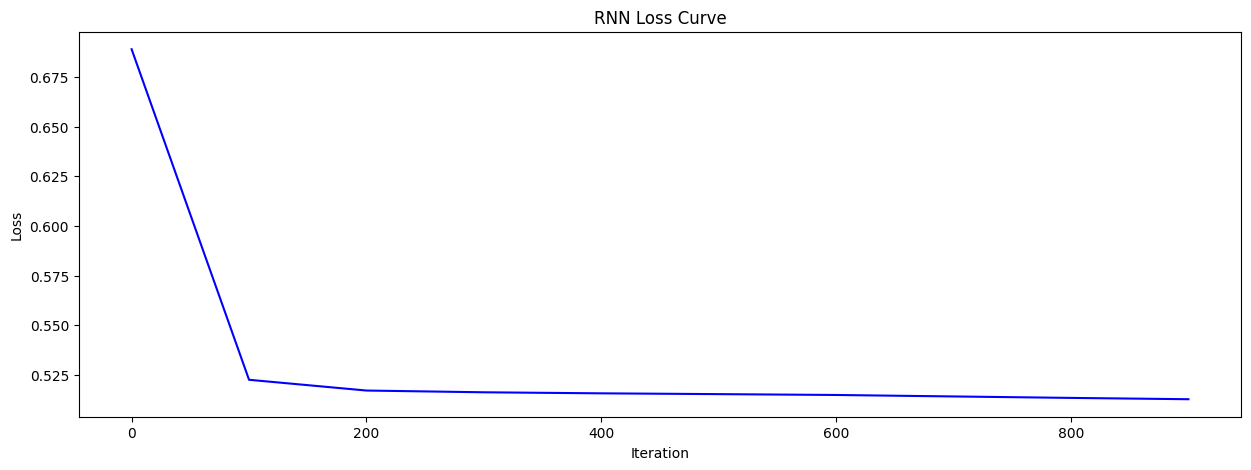

AUC on dev set = 0.7835119013402551


In [17]:
# 使用RNN
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
import torch
from sklearn.preprocessing import MinMaxScaler
import time


# 定义神经元
class Net(nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        # 隐藏层线性输出
        self.hidden = nn.Linear(n_feature, n_hidden)
        # self.hidden1 = nn.Linear(n_hidden, n_hidden)
        # 输出层线性输出
        self.out = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        # 前向传播
        x = torch.softmax(self.hidden(x), dim=1)  # 激励函数(隐藏层的非线性值)
        # x = torch.sigmoid(self.hidden1(x))
        x = self.out(x)  # 输出值（预测值另算）
        return x


user_columns = ['user_id', 'count', 'duration_avg', 'success_count', 'win_duration_avg', 'fail_duration_avg',
                'win_reststep_avg', 'fail_reststep_avg', 'retry_times_avg', 'date_covered',
                'max_level', 'last_level', 'level_num', 'last_level_pass', 'uf_avg_duration', 'uf_avg_passrate',
                'uf_avg_win_duration', 'uf_avg_retrytimes']

# 加载数据
train_df = pd.read_csv('./data/train.csv', sep='\t')
dev_df = pd.read_csv('./data/dev.csv', sep='\t')
test_df = pd.read_csv('./data/test.csv', sep='\t')
user_analyze_df = pd.read_csv('./user_analyze.csv')
user_test_analyze_df = pd.read_csv('./user_test_analyze.csv')

train_feat_df = train_df.merge(user_analyze_df, how='left', on='user_id')
x_train = train_feat_df[user_columns]
y_train = train_feat_df['label']
dev_feat_df = dev_df.merge(user_analyze_df, how='left', on='user_id')
x_dev = dev_feat_df[user_columns]
y_dev = dev_feat_df['label']
test_feat_df = test_df.merge(user_test_analyze_df, how='left', on='user_id')
x_test = test_feat_df[user_columns]
x_all = pd.concat([x_train, x_dev, x_test])
x_all.set_index('user_id', inplace=True)
# 归一化数据
x_all = x_all.apply(lambda x: (x - min(x)) / (max(x) - min(x)))
user_columns.remove('user_id')
x_train = train_df.merge(x_all, how='left', on='user_id')[user_columns]
x_dev = dev_df.merge(x_all, how='left', on='user_id')[user_columns]
x_test = test_df.merge(x_all, how='left', on='user_id')[user_columns]

# 建立神经网络
iter_num = 1000
n_feature = len(user_columns)
net = Net(n_feature=n_feature, n_hidden=5, n_output=2)
print('net:\n', net)
# 训练网络
x_train_tensor = torch.from_numpy(x_train.values.astype('float32'))
y_train_tensor = torch.from_numpy(y_train.values)
optimizer = optim.Adam(net.parameters(), lr=1e-2)
loss_func = nn.CrossEntropyLoss()  # 误差形式是1D Tensor，预测值是2D Tensor (batch, n_classes)
loss_arr = []
step = 100
for i in range(iter_num):
    out = net(x_train_tensor)
    loss = loss_func(out, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % step == 0:
        prediction = torch.softmax(out, dim=1).detach().numpy()
        print("Iteration: {}, Loss: {}, Train AUC: {}".format(i, loss.item(), roc_auc_score(y_train, prediction[:, 1])))
        loss_arr.append(loss.item())

# 展现损失函数趋势
plt.figure(figsize=(15, 5))
plt.plot(range(0, iter_num, step), loss_arr, color='blue')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('RNN Loss Curve')
plt.show()

# 验证集上使用模型，用于调参
x_dev_tensor = torch.from_numpy(x_dev.values.astype('float32'))
y_dev_predict = torch.softmax(net(x_dev_tensor), dim=1).detach().numpy()
y_rnn_predict_proba = y_dev_predict[:, 1]
print('AUC on dev set = {}'.format(roc_auc_score(y_dev, y_rnn_predict_proba)))

# 生成结果文件
x_test_tensor = torch.from_numpy(x_test.values.astype('float32'))
y_predict = torch.softmax(net(x_test_tensor), dim=1).detach().numpy()
y_predict_final_2 = y_predict[:, 1]
result_df = pd.DataFrame()
result_df['ID'] = test_df['user_id'].values
result_df['Prediction'] = y_predict[:, 1]
result_df.to_csv('./result-rnn-{}.csv'.format(round(time.time())), index=False)

### 2022-11-27：将Bagging+DTree与RNN各自预测结果简单平均作为最终结果

In [18]:
# 将Bagging+DTree与RNN各自训练结果简单平均
# y_bagg_dt_predict_proba
# y_rnn_predict_proba
y_dev_predict_proba = (y_bagg_dt_predict_proba + y_rnn_predict_proba) / 2
print("AUC for average Bagg+Dtree & Rnn = {}".format(roc_auc_score(y_dev, y_dev_predict_proba)))
y_predict_final = (y_predict_final_1 + y_predict_final_2) / 2
# 生成结果文件
result_df = pd.DataFrame()
result_df['ID'] = test_df['user_id'].values
result_df['Prediction'] = y_predict_final
result_df.to_csv('./result-{}.csv'.format(round(time.time())), index=False)

AUC for average Bagg+Dtree & Rnn = 0.7859792793310665
